In [21]:
import pickle as pkl
import networkx as nx
with open("largest_component_graph.pkl", "rb") as f: 
 G = pkl.load(f)

# Community Detection with Louvain algorithm for the whole show

In [32]:
import community  

# Detect communities with the Louvain method
partition = community.best_partition(G)  # Maps each node to its community number
print(f"Number of Communities: {len(set(partition.values()))}")


Number of Communities: 24


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from fa2_modified import ForceAtlas2  
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Determine the size of each community
community_sizes = {}
for node, community in partition.items():
    community_sizes[community] = community_sizes.get(community, 0) + 1

# Sort communities by size and select the top 10
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
top_communities = {comm: idx for idx, (comm, _) in enumerate(sorted_communities[:10])}

# Assign colors to top 10 communities; others are greyed out
color_map = list(mcolors.TABLEAU_COLORS.values())  # Predefined set of colors
default_color = (0.7, 0.7, 0.7, 1)  # Grey for non-top communities
node_colors = {
    node: color_map[top_communities[community] % len(color_map)] if community in top_communities else default_color
    for node, community in partition.items()
}
node_color_list = [node_colors[node] for node in G.nodes()]

# Scale node sizes based on scene count
scene_counts = nx.get_node_attributes(G, "scene_count")
max_scene_count = max(scene_counts.values()) if scene_counts else 1
node_sizes = [500 + (1000 * scene_counts[node] / max_scene_count) * 10 for node in G.nodes()]

# Compute positions with ForceAtlas2
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=1,
    jitterTolerance=1,
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.0000001,
    strongGravityMode=False,
    gravity=0.00001,
    verbose=False
)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Define a scaling factor and cap for edge widths
scaling_factor = 0.3
max_width = 6  # Maximum edge width
edge_widths = [
    min(G[u][v].get('weight', 1) * scaling_factor, max_width) 
    for u, v in G.edges()
]

plt.figure(figsize=(30, 30))
ax = plt.gca()
plt.axis("off")

# Draw edges as curved lines
for ((u, v), w) in zip(G.edges(), edge_widths):
    x1, y1 = positions[u]
    x2, y2 = positions[v]

    # Blend node colors
    color_u = mcolors.to_rgba(node_colors[u])
    color_v = mcolors.to_rgba(node_colors[v])
    blended_color = [(color_u[i] + color_v[i]) / 2 for i in range(4)]  

    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        connectionstyle="arc3,rad=0.2",  
        color=blended_color,
        alpha=0.7,
        linewidth=w,
        arrowstyle='-'
    )
    ax.add_patch(arrow)

# Draw nodes on top of edges
nx.draw_networkx_nodes(
    G, positions,
    node_color=node_color_list,
    node_size=node_sizes,
    ax=ax
)

# Identify key nodes for labeling
percentage = 75
threshold = np.percentile(list(scene_counts.values()), 100 - percentage)
key_nodes = [node for node, attr in G.nodes(data=True) if attr["scene_count"] > threshold]

# Draw labels on top of nodes
nx.draw_networkx_labels(
    G, positions,
    labels={node: node for node in key_nodes}, 
    font_size=10,
    font_weight="medium",
    ax=ax
)

# Add a legend for top 10 communities
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[idx % len(color_map)], markersize=10, label=f"Community {comm}")
    for comm, idx in top_communities.items()
]
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=default_color, markersize=10, label="Other Communities"))
ax.legend(handles=legend_handles, title="Communities", loc="lower right", fontsize=10)

plt.title("Community Visualization with Top 10 Highlighted", fontsize=20)
plt.show()


In [ ]:
import community as community_louvain 


modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partitioning into communities: {modularity}")


Modularity of the partitioning into communities: 0.254836500518176


With a modularity of ~ 0.25, the network shows a notable but not extremely strong division into communities. This suggests the communities are meaningful but might still have overlap or weaker boundaries compared to more tightly clustered networks.

In [15]:
from collections import defaultdict

# Group nodes by community
communities = defaultdict(list)
for node, community_id in partition.items():
    communities[community_id].append(node)

# Print the nodes in each community
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")


Community 0: ['katara', 'sokka', 'aang', 'kanna', 'village girl', 'southern water tribe boy', 'southern water tribe girl', 'firebender', 'oyaji', 'suki', 'fisherman', 'gate guard', 'bumi', 'chamberlain', 'old wanderer', 'senlin village leader', 'pirate', 'eye-patch soldier', "fisherman's wife", 'calm man', 'strange man', 'meng', 'woman', 'wu', 'village woman', 'man with red shoes', 'hakoda', 'bato', 'mother superior', 'messenger', 'mask dealer', 'shop keeper', 'chey', 'lin yee', 'jeong jeong', 'tribal man', 'storyteller', 'colonists', 'arnook', 'yue', 'pakku', 'yugoda', 'hahn', 'baboon spirit', 'koh', 'fong', 'oracle', 'chong', 'moku', 'lily', 'toph', 'guard one', 'guard two', 'princess yue', 'merchant', 'tong', 'kyoshi', 'audience', 'zei', 'wan shi tong', 'than', 'ying', 'ticket lady', 'earthbender guard', 'general sung', 'terra team member', 'joo dee', 'pet store owner', 'university student', 'pong', 'long feng', 'guest', 'joo dee replacement', 'girl with umbrella', 'lady on stage', 

### **1. Community Modularity**
The modularity score of **0.25** suggests that the detected communities are reasonably well-separated but not entirely independent of one another. This makes sense given the nature of "Avatar," where characters frequently cross paths due to shared plotlines or overarching conflicts. It’s not surprising that the central protagonists—**Aang**, **Katara**, and **Sokka**—bridge multiple arcs and act as connectors between communities, as seen earlier in the network analysis. Let’s now unpack the specific communities.

### **2. Community Breakdown**
The Louvain algorithm divided the network into distinct groups, many of which correspond to narrative or geographic divisions within the show:

#### **Community 0 (Team Avatar and Key Allies)**
This is by far the largest and most diverse community, encompassing **Aang**, **Katara**, **Sokka**, and their close allies like **Toph**, **Suki**, and **Bumi**. It also includes numerous supporting characters from various arcs, such as the Water Tribe, Earth Kingdom, and other key storylines.

- **Why is it so large?** This reflects the centrality of Team Avatar in the story. As we saw earlier in the network analysis, Aang, Katara, and Sokka are the most connected characters, serving as hubs for interactions across the narrative.
- **Diversity of characters:** This community includes figures as diverse as **Wan Shi Tong** (a spiritual entity), **Pakku** (Water Tribe elder), and even **Lion Turtle** (a mythological figure). This diversity highlights how the core group’s journey ties together vastly different parts of the world and story. It makes sense that most of the sprits would be in this community because of their relation to Aang.

#### **Community 1 (Fire Nation Characters)**
This community is centered around **Zuko**, **Azula**, **Iroh**, and other Fire Nation characters. It also includes characters like **Lo and Li**, **Mai**, **Ty Lee**, and **Zhao**.

- **Cluster dynamics:** Compared to Community 0, this group is more cohesive, reflecting the Fire Nation’s relative insularity in much of the series. However, **Zuko** and **Iroh**, as noted in the earlier network analysis, serve as bridges to other groups, especially as their arcs progress.
- **Interesting inclusion:** The presence of characters like **Chan** and **Ruon-Jian** (from the Ember Island episodes) adds nuance, emphasizing how even lighter, comedic episodes fit within the larger network.

#### **Community 2 (Avatar Roku and Historical Figures)**
This smaller community features characters like **Avatar Roku**, **Sozin**, and **Gyatso**, reflecting its focus on the backstory and the connection between past and present events.

- **Historical significance:** This group is disconnected from the main action, which mirrors their role as a narrative backdrop. However, their influence on the present is felt strongly, especially through Aang’s interactions with Roku.

#### **Community 5 (The Freedom Fighters and Minor Outcasts)**
This community includes **Jet**, **Smellerbee**, **The Duke**, and other outcasts, as well as characters like **Teo** and **The Mechanist**.

- **Narrative focus:** These characters are united by themes of rebellion and resistance, whether it’s Jet’s Freedom Fighters or Teo’s engineering crew.
- **Peripheral role:** As noted in the network analysis, this group’s relative isolation reflects their limited, arc-specific interactions with Team Avatar.

#### **Community 3 (The Ember Island Players)**
This unique cluster groups together the actors who parodied the main characters in the **Ember Island Players** episode.

- **A distinct community:** Their separation from the main communities underscores their meta role within the story. It’s fascinating how even this comedic group forms its own cohesive cluster, highlighting the richness of the network.

#### **Smaller Communities**
The remaining communities consist of smaller, more tightly-knit groups of characters, often tied to specific arcs or episodes:
- **Community 6:** Members of the **Gan Jin** and **Zhang Tribes**, whose feud is resolved by Aang in 'The Great Divide' episode.
- **Community 16:** The students and headmaster from **The Headband** episode, highlighting the Fire Nation’s civilian life.

These smaller clusters emphasize the episodic nature of some arcs while still showing how they’re integrated into the broader story.

### **3. Patterns and Observations**
The community structure reveals some intriguing patterns:
- **Proximity to Aang and Team Avatar:** Characters from the **Water Arc** (Community 0) cluster tightly around Aang, Katara, and Sokka. This mirrors the observation from the network analysis that Water Arc characters are more central due to their proximity to the main trio.
- **Fire Nation dispersion:** Fire Nation characters (Community 1) tend to be more spread out, reflecting their varying degrees of involvement in the main story. This aligns with the earlier finding that red nodes were more peripheral in the graph.
- **Earth Kingdom diversity:** The **Earth Arc** characters are spread across multiple communities (e.g., Communities 0, 5, and 6). This reflects the Earth Kingdom’s narrative complexity and its vast geography, which introduces many isolated subplots.


### **4. Themes in the Clusters**
The clustering results also align closely with some of the series' major themes:
- **Connection vs. Isolation:** The dense central communities reflect the interconnected nature of Aang’s journey, while the smaller, isolated clusters highlight episodic or arc-specific groups.
- **Evolution of relationships:** Characters like Zuko and Iroh, who bridge multiple communities, reflect the transformative power of relationships, a key theme of the series.

### **Conclusion**
This community detection analysis enriches our understanding of the network. It reveals not only how characters naturally group based on their roles and arcs but also highlights the interconnectedness of the narrative. From the sprawling, central cluster of Team Avatar to the isolated group of Ember Island Players, the clusters map out the story’s depth and complexity. Combined with the earlier network analysis, this provides a detailed picture of how "Avatar: The Last Airbender" balances episodic storytelling with a deeply interconnected world. If you’d like, we can explore specific communities or analyze their roles further!

# Relationships for each season

Lets try exploring the communities that form each season.

In [ ]:
import networkx as nx
import pandas as pd
import community
import matplotlib.pyplot as plt

# Load the data
connections_by_book_df = pd.read_csv('character_connections_by_book.csv')
character_attributes_df = pd.read_csv('character_attributes_by_arc.csv')  # Load character attributes by arc

# Separate data by book
books = ['Water', 'Earth', 'Fire']
graphs_by_book = {}
partitions_by_book = {}
modularities = {}
centrality_metrics = {}

# Create a dictionary for character attributes grouped by arc (book)
character_attributes_by_book = character_attributes_df.groupby('arc', as_index=False, group_keys=False).apply(
    lambda group: group.set_index('character').to_dict(orient='index')
).to_dict()


# Define a function to adjust weights based on sentiment
def adjust_weight(weight, sentiment):
    # Cap sentiment influence to avoid negative weights
    sentiment_factor = max(0, 1 + sentiment)  # Ensure factor is always >= 0
    return weight * sentiment_factor


# Recompute graphs with sentiment-adjusted weights and include attributes
graphs_by_book_sentiment = {}
partitions_by_book_sentiment = {}

for book in books:
    G_sentiment = nx.Graph()

    # Adjust edge weights based on sentiment
    book_data = connections_by_book_df[connections_by_book_df['book'] == book]
    for _, row in book_data.iterrows():
        pair = eval(row['pair'])
        sentiment = row.get('average_sentiment_between_characters', 0)  
        adjusted_weight = adjust_weight(row['count'], sentiment)
        G_sentiment.add_edge(pair[0], pair[1], weight=adjusted_weight, sentiment=sentiment)

    # Add character attributes to nodes
    if book in character_attributes_by_book:
        book_attributes = character_attributes_by_book[book]
        for node in G_sentiment.nodes():
            if node in book_attributes:
                # Add character attributes from the current arc
                nx.set_node_attributes(G_sentiment, {node: book_attributes[node]})
            else:
                nx.set_node_attributes(G_sentiment, {node: {}})  # Default empty attributes for missing data

    # Extract the largest connected component
    largest_component = max(nx.connected_components(G_sentiment), key=len)
    G_sentiment = G_sentiment.subgraph(largest_component).copy()

    # Detect communities using sentiment-adjusted weights
    partition = community.best_partition(G_sentiment, weight='weight')
    partitions_by_book_sentiment[book] = partition

    # Store the sentiment-adjusted graph
    graphs_by_book_sentiment[book] = G_sentiment

    # Calculate modularity
    modularity = community.modularity(partition, G_sentiment)
    modularities[book] = modularity

    # Calculate centrality metrics
    centrality_metrics[book] = {
        'Degree Centrality': nx.degree_centrality(G_sentiment),
        'Betweenness Centrality': nx.betweenness_centrality(G_sentiment, weight='weight'),
        'Closeness Centrality': nx.closeness_centrality(G_sentiment, distance='weight'),
        'Eigenvector Centrality': nx.eigenvector_centrality(G_sentiment, weight='weight')
    }


# Display modularity results
print("Modularity for each book:")
for book, modularity in modularities.items():
    print(f"{book}: {modularity:.4f}")

# Compare centralities across books
centrality_comparison = {}
for metric in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    centrality_comparison[metric] = {}
    for book, metrics in centrality_metrics.items():
        # Get the top 5 characters for the current metric
        sorted_centrality = sorted(metrics[metric].items(), key=lambda x: x[1], reverse=True)
        centrality_comparison[metric][book] = sorted_centrality[:5]

# Display top 5 central characters for each centrality metric and book
for metric, data in centrality_comparison.items():
    print(f"\nTop 5 Characters by {metric}:")
    for book, top_characters in data.items():
        print(f"  {book}:")
        for char, score in top_characters:
            print(f"    {char}: {score:.4f}")


/var/folders/0q/x2dyyz5d7xs7zzrfhj8l86840000gp/T/ipykernel_62766/1529612775.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  character_attributes_by_book = character_attributes_df.groupby('arc', as_index=False, group_keys=False).apply(


Modularity for each book:
Water: 0.2010
Earth: 0.3297
Fire: 0.2866

Top 5 Characters by Degree Centrality:
  Water:
    aang: 0.6757
    sokka: 0.6126
    katara: 0.5676
    zuko: 0.2162
    zhao: 0.1712
  Earth:
    aang: 0.4255
    sokka: 0.4113
    katara: 0.3759
    toph: 0.2270
    zuko: 0.2128
  Fire:
    aang: 0.4206
    sokka: 0.4048
    katara: 0.3095
    toph: 0.3016
    zuko: 0.2778

Top 5 Characters by Betweenness Centrality:
  Water:
    warden: 1.7593
    sokka: 0.9609
    aang: 0.3172
    zuko: 0.2226
    katara: 0.1638
  Earth:
    sokka: 14.0863
    katara: 1.7898
    mai: 0.3246
    aang: 0.3159
    zuko: 0.2311
  Fire:
    aang: 0.4697
    katara: 0.2312
    warden: 0.1994
    zuko: 0.1826
    sokka: 0.1600

Top 5 Characters by Closeness Centrality:
  Water:
    sokka: 0.5894
    june: 0.5894
    storyteller: 0.5894
    colonists: 0.5894
    pirate: 0.5566
  Earth:
    aang: 0.7588
    katara: 0.7588
    sokka: 0.7588
    oracle: 0.7588
    toph: 0.7588
  Fire:
    a

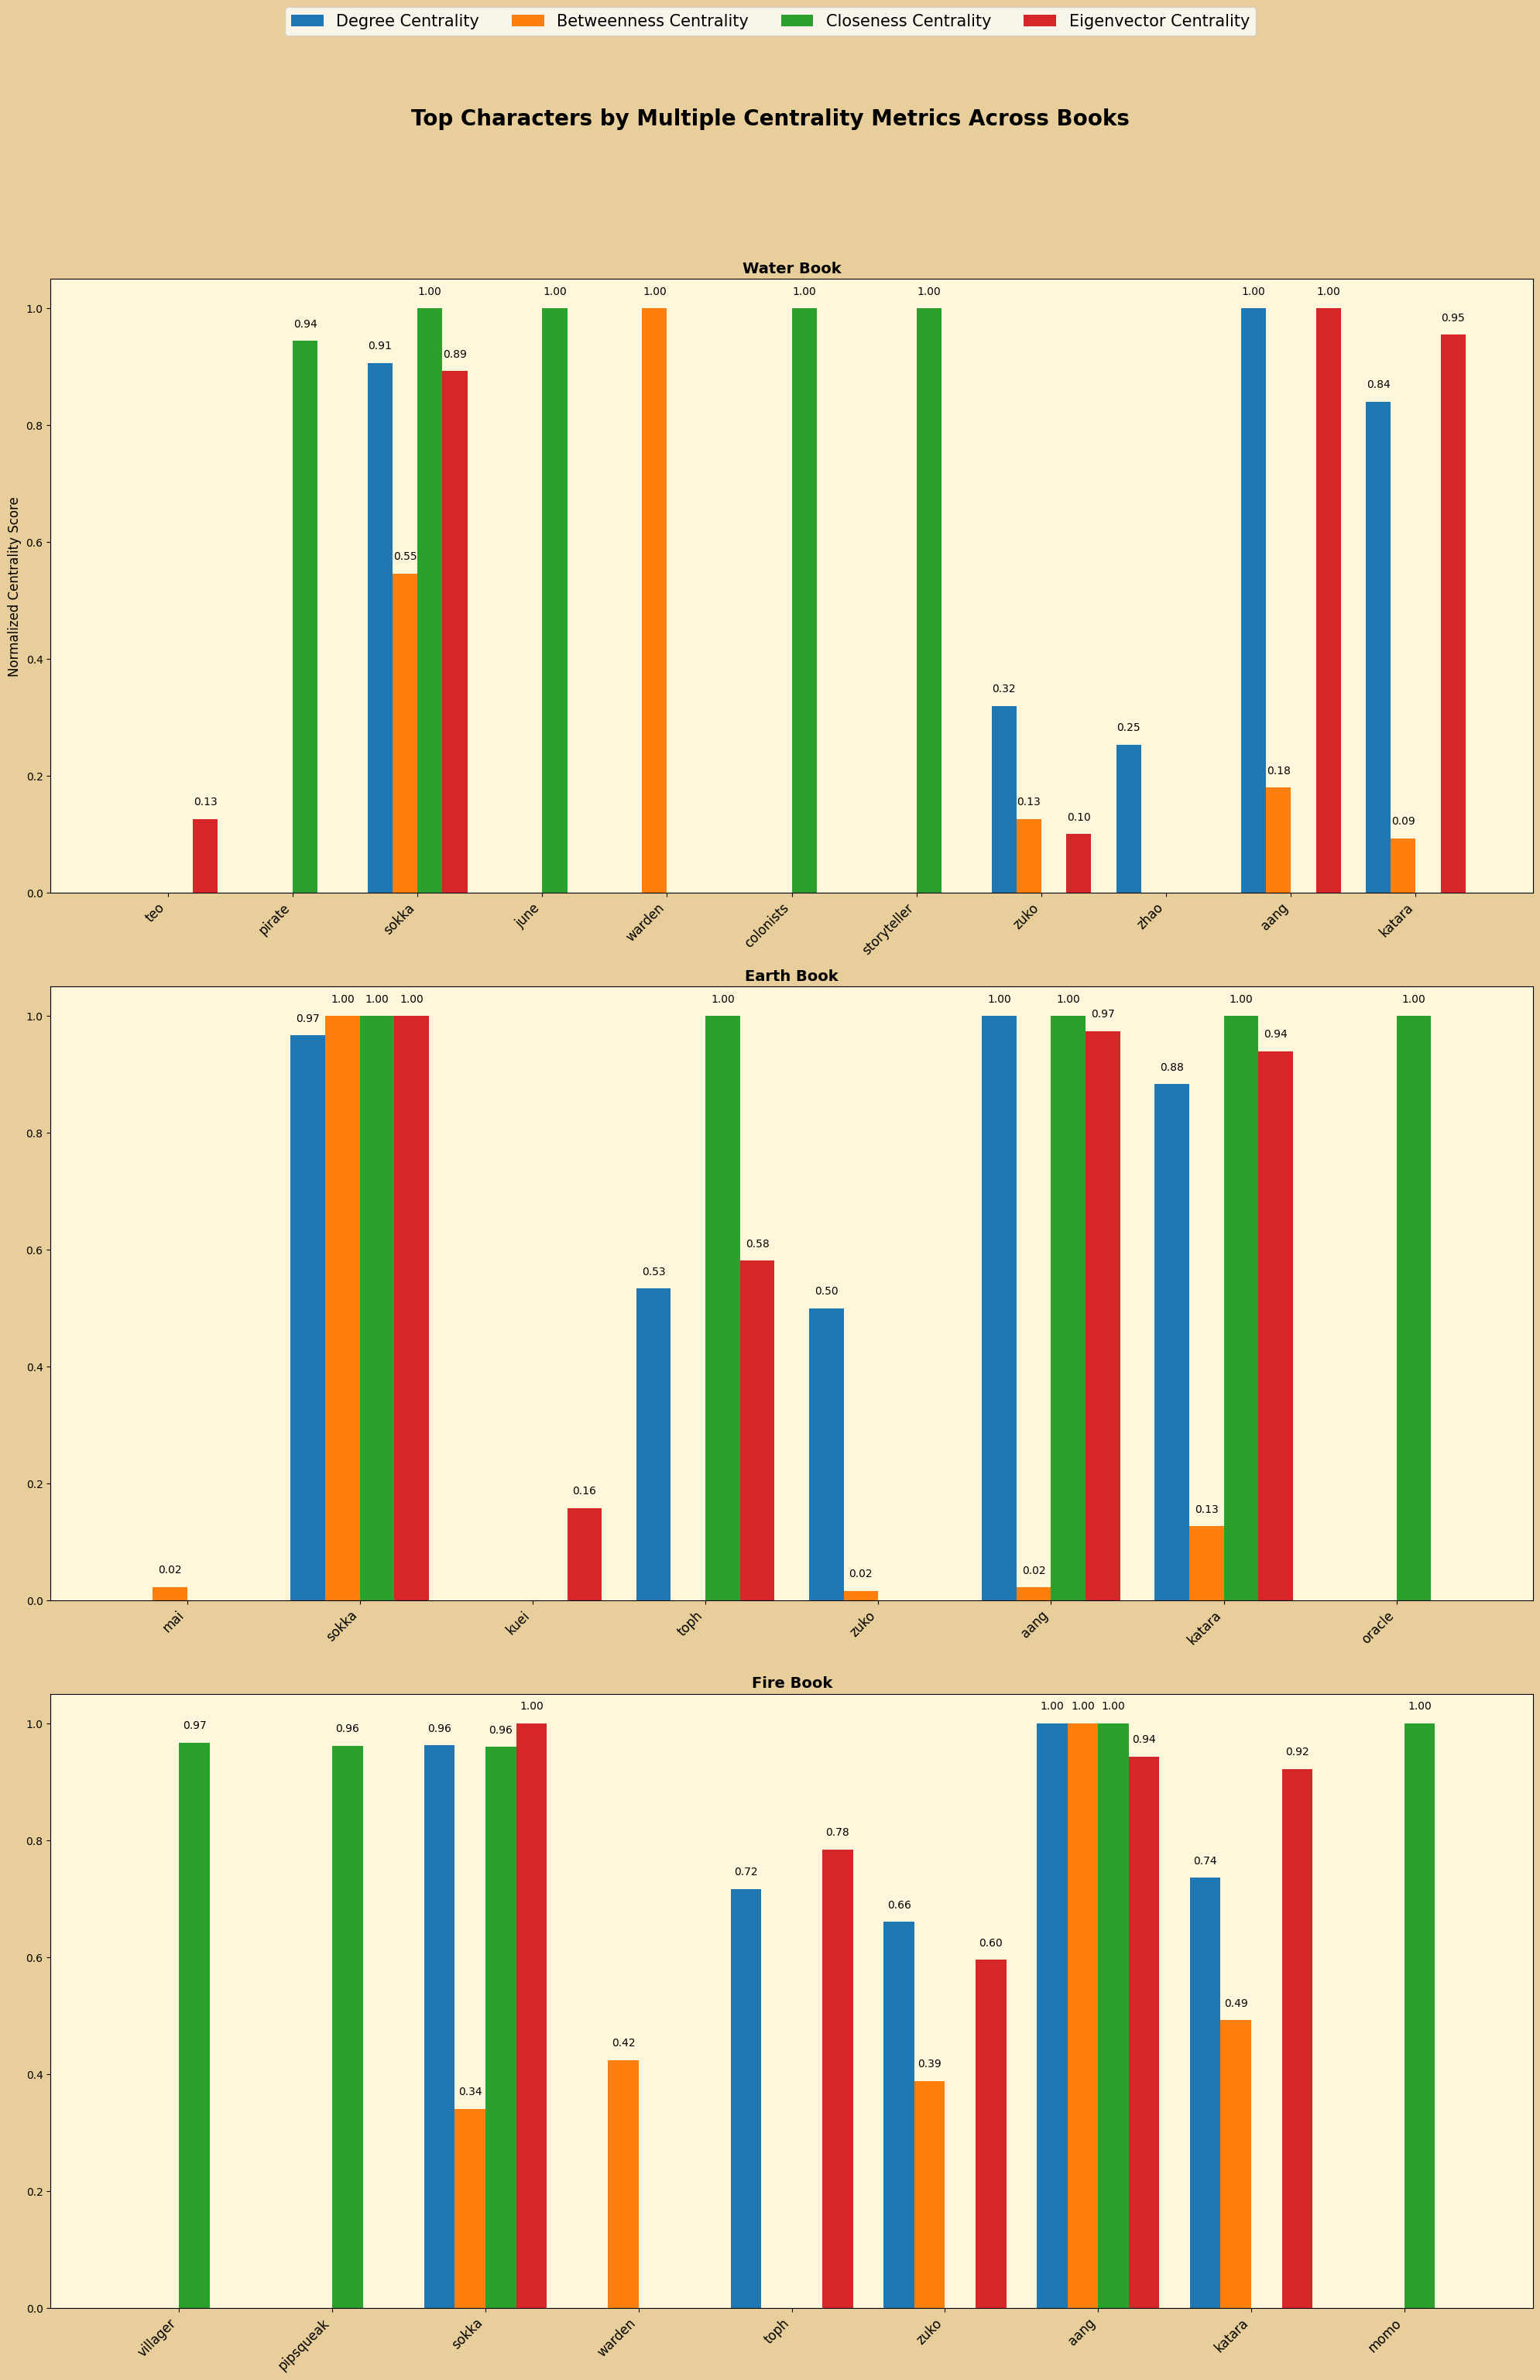

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']
books = list(centrality_comparison['Degree Centrality'].keys())  # Extract the books from one of the metrics

# Create a figure with subplots for each book
fig, axes = plt.subplots(len(books), 1, figsize=(20, 28), sharey=True)

# Set the figure background color
beige = (254 / 255, 247 / 255, 219 / 255)  # Normalize RGB to [0, 1] range

desert_sand = (231 / 255, 206 / 255, 154 / 255)
fig.patch.set_facecolor(desert_sand)


for idx, book in enumerate(books):
    ax = axes[idx]  # Get the subplot axis for the current book
    # Set the subplot background color
    ax.set_facecolor(beige)

    # Collect all top characters from all metrics for this book
    all_chars = set()
    scores_by_metric = {}
    max_scores_by_metric = {}
    
    for metric in metrics:
        top_data = centrality_comparison[metric][book]  
        # Extract characters and scores
        chars = [x[0] for x in top_data]
        scores = [x[1] for x in top_data]
        
        # Find max score for normalization
        max_score = max(scores) if len(scores) > 0 else 1  # Avoid division by zero
        max_scores_by_metric[metric] = max_score
        
        # Store scores in a dict for this metric
        metric_scores_dict = {c: s for c, s in top_data}
        scores_by_metric[metric] = metric_scores_dict
        
        # Add to the set of all characters to show
        all_chars.update(chars)
    
    # Convert all_chars to a list to maintain order
    all_chars = list(all_chars)
    
    # Prepare data for plotting
    # For each character, we will have one group with a bar for each metric
    # Normalize scores by dividing by the metric max
    plot_data = []
    for metric in metrics:
        metric_scores = []
        for c in all_chars:
            # Get score if character in top 5, else 0
            raw_score = scores_by_metric[metric].get(c, 0)
            normalized = raw_score / max_scores_by_metric[metric] if max_scores_by_metric[metric] > 0 else 0
            metric_scores.append(normalized)
        plot_data.append(metric_scores)
    
    # Create the grouped bar chart
    x = np.arange(len(all_chars))  # positions for the groups
    bar_width = 0.2
    
    for i, metric in enumerate(metrics):
        # Offset for each metric
        offset = (i - (len(metrics)-1)/2) * bar_width
        ax.bar(x + offset, plot_data[i], width=bar_width, label=metric if idx == 0 else None)  # Label only for the first subplot
    
    ax.set_xticks(x)
    ax.set_xticklabels(all_chars, rotation=45, ha='right', fontsize=12)
    ax.set_title(f'{book} Book', fontsize=14, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('Normalized Centrality Score', fontsize=12)

    # Annotate the bars with the actual values
    for i, metric_scores in enumerate(plot_data):
        offset = (i - (len(metrics)-1)/2) * bar_width
        for j, val in enumerate(metric_scores):
            if val > 0:
                ax.text(j + offset, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Add a shared legend outside the subplots
fig.legend(metrics, loc='upper center', ncol=len(metrics), bbox_to_anchor=(0.5, 1.1), fontsize=15)
fig.suptitle('Top Characters by Multiple Centrality Metrics Across Books', fontsize=20, y=1.05, fontweight='bold')
plt.tight_layout()
plt.show()


### **1. Modularity Across Books**
- **Water Book (0.2010)**: The relatively low modularity suggests weaker community divisions, which fits the series' introduction to the characters and their connections. Team Avatar is forming, and relationships are more exploratory, with fewer established factions.
- **Earth Book (0.3297)**: A higher modularity score reflects the complexity of the Earth Kingdom setting. This season introduces Ba Sing Se’s politics, Toph’s role, and larger, more distinct groups like the Dai Li.
- **Fire Book (0.2866)**: The modularity lies between Water and Earth, suggesting a shift back to a more focused narrative but with multiple factions (e.g., the Fire Nation, Team Avatar, and rebel groups) playing key roles.

### **2. Centrality Insights by Book**

#### **Water Book**
- **Degree Centrality**:
  - **Aang (0.6757)**, **Sokka (0.6126)**, and **Katara (0.5676)** dominate, emphasizing their shared roles as protagonists and their frequent interactions.
  - **Zuko (0.2162)**: His lower score reflects his role as a recurring antagonist in the Water Book, where he primarily interacts with Team Avatar rather than forming broader connections.
  - **Zhao (0.1712)**: As a secondary antagonist, Zhao’s lower degree centrality reflects his limited but impactful presence in this book.
- **Betweenness Centrality**:
  - **Warden (1.7593)** stands out, likely due to his pivotal role in connecting characters during the Northern Water Tribe sequence. His importance here reflects his plot-specific role.
  - **Sokka (0.9609)** ranks highly, reinforcing his tactical and logistical contributions, even this early in the series.
- **Closeness Centrality**:
  - Characters like **June**, the **Storyteller**, and **Pirates** score unusually high here. This highlights episodic characters whose actions briefly but significantly affect the story, creating shortcuts in the narrative flow.
- **Eigenvector Centrality**:
  - **Aang (0.5969)**, **Katara (0.5699)**, and **Sokka (0.5328)** lead again, showing their influence across the season.

#### **Earth Book**
- **Degree Centrality**:
  - **Aang (0.4255)**, **Sokka (0.4113)**, and **Katara (0.3759)** continue to dominate, but **Toph (0.2270)** makes her debut, underscoring her growing importance as a new member of Team Avatar.
  - **Zuko (0.2128)**: His score reflects increased involvement in the broader story as his internal conflict becomes more central.
- **Betweenness Centrality**:
  - **Sokka (14.1929)** leads significantly, a testament to his role as a strategist and planner during the Earth Kingdom arcs.
  - **Mai (0.3246)** appears here, reflecting her interactions with Zuko and Team Avatar, hinting at her evolving relevance.
- **Closeness Centrality**:
  - **Aang**, **Katara**, **Sokka**, and **Toph** score equally high, reflecting their unified presence across the season’s narrative arcs.
- **Eigenvector Centrality**:
  - **Sokka (0.5539)** surpasses Aang (0.5395), emphasizing his role as the team’s tactician and a key influencer in the Earth Kingdom’s various arcs.

#### **Fire Book**
- **Degree Centrality**:
  - **Aang (0.4206)**, **Sokka (0.4048)**, and **Katara (0.3095)** maintain high scores, but **Zuko (0.2778)** rises significantly. This reflects his integration into Team Avatar and his pivotal role in the final conflict.
  - **Toph (0.3016)** remains steady, reinforcing her consistent contributions.
- **Betweenness Centrality**:
  - **Aang (0.4788)** leads, reflecting his role as the Avatar and the center of the conflict with the Fire Nation.
  - **Katara (0.2304)** and **Zuko (0.1840)** follow, emphasizing their critical roles in uniting Team Avatar and resolving personal arcs.
- **Closeness Centrality**:
  - **Aang (0.7567)** and **Momo (0.7567)** score highest, suggesting their omnipresence and accessibility within the network.
  - **Villager** and **Pipsqueak** scoring highly highlights the Fire Book’s episodic moments where these characters interact meaningfully with the core group
- **Eigenvector Centrality**:
  - **Sokka (0.5078)** leads, reflecting his strategic influence, followed closely by **Aang (0.4788)** and **Katara (0.4682)**.

### **3. Narrative and Structural Observations**
- **Team Avatar’s Role**:
  Across all three books, Aang, Katara, and Sokka dominate centrality metrics, confirming their consistent importance. However, the subtle shifts—like Sokka’s dominance in **Earth Book’s betweenness centrality** and Zuko’s rising degree and eigenvector centrality in the **Fire Book**—reflect their evolving roles.
- **Zuko’s Arc**:
  Zuko’s rise across all centrality metrics from Water to Fire mirrors his transformation from antagonist to a critical member of Team Avatar. By the Fire Book, his high scores demonstrate his dual role as a fighter and a bridge between factions.
- **Sokka’s Influence**:
  Sokka’s high betweenness centrality, especially in the Earth Book, shows how his role as a strategist often positions him as the glue that holds Team Avatar’s plans together.
- **Seasonal Themes**:
  - **Water Book**: The lower modularity and centrality scores for non-core characters highlight a narrative focused on establishing Team Avatar and their enemies.
  - **Earth Book**: Higher modularity reflects the story’s complexity, with multiple communities like the Dai Li, Ba Sing Se, and Toph’s introduction creating a denser network.
  - **Fire Book**: The modularity remains high but slightly lower than Earth, reflecting the convergence of storylines as the finale approaches.

### **4. Thematic and Network Connections**
The metrics align well with our earlier discussions:
- The **Louvain clustering results** showed Team Avatar’s core dominance, which is reaffirmed here by their high centrality across seasons.
- The **Fire Nation’s dispersion** as seen in the community analysis is mirrored by Zuko’s rising centrality, as he connects previously separate factions.
- The **Earth Book’s political complexity**, noted in its modularity, is evident in Sokka’s high centrality scores, reflecting his role in navigating alliances and conflicts.



### **Villager's High Closeness Centrality**
The surprisingly high closeness centrality for "Villager" in the Fire Book could indeed be attributed to a data issue. "Villager" might represent multiple unnamed characters in the network, all grouped under the same label. This could artificially inflate their metrics, as their collective interactions would be aggregated as if they were one person.

- **Implications**: While this doesn’t detract from the broader analysis, it’s a reminder that anonymized or generic nodes in the network can sometimes misrepresent the true structure. It would be worth revisiting the dataset to see if these nodes can be disaggregated into distinct entities or left out of centrality calculations if they aren’t central to the narrative.

### **Pipsqueak's Role in the Fire Book**
The higher centrality of Pipsqueak in the Fire Book is genuinely fascinating and perfectly aligns with the narrative. In the final season, **Pipsqueak and The Duke** step up as key allies in the resistance movement against the Fire Nation. This aligns with the increasing action and stakes of the story.

- **Context**: In earlier seasons, Pipsqueak and The Duke were more closely associated with Jet and the Freedom Fighters, a group largely isolated from the main plotlines (as reflected in Community 3 from the Louvain clustering results). However, by the Fire Book, they join Team Avatar’s efforts to overthrow Fire Nation forces, making them more integrated into the central conflict.
- **Significance**: Pipsqueak’s rising centrality metrics reflect his involvement in key battles, including aiding Sokka’s plans and participating in action-heavy sequences. This mirrors how the Fire Book’s more action-packed, military-driven narrative brings many secondary characters to the forefront.

### **Seasonal Action and Network Dynamics**
- **Pipsqueak and The Duke**: Their higher presence in the action-heavy Fire Book aligns with the need for more fighters and strategists as Team Avatar faces larger, coordinated battles.
- **Sokka’s Tactical Role**: Sokka’s consistent prominence across betweenness centrality metrics, especially in the Fire Book, underscores his leadership in coordinating these battles.
- **Villager and Ambiguous Nodes**: While high centrality for "Villager" might suggest data issues, it could also reflect the narrative’s growing reliance on the masses—ordinary people joining the rebellion against the Fire Nation.


## Visualization of the graphs
The sentiment-based graphs for each season offer a fascinating look into not only the structure of character relationships but also the emotional tone and how it evolves over time. These graphs, which include a sentiment bias I applied (adding a bias of 1.5 to both positive and negative sentiments to counteract the show’s overall neutral tone), reveal some intriguing patterns and dynamics. Let’s break this down book by book.

Dynamic Thresholds -> Negative: <-0.4676, Positive: >0.2944


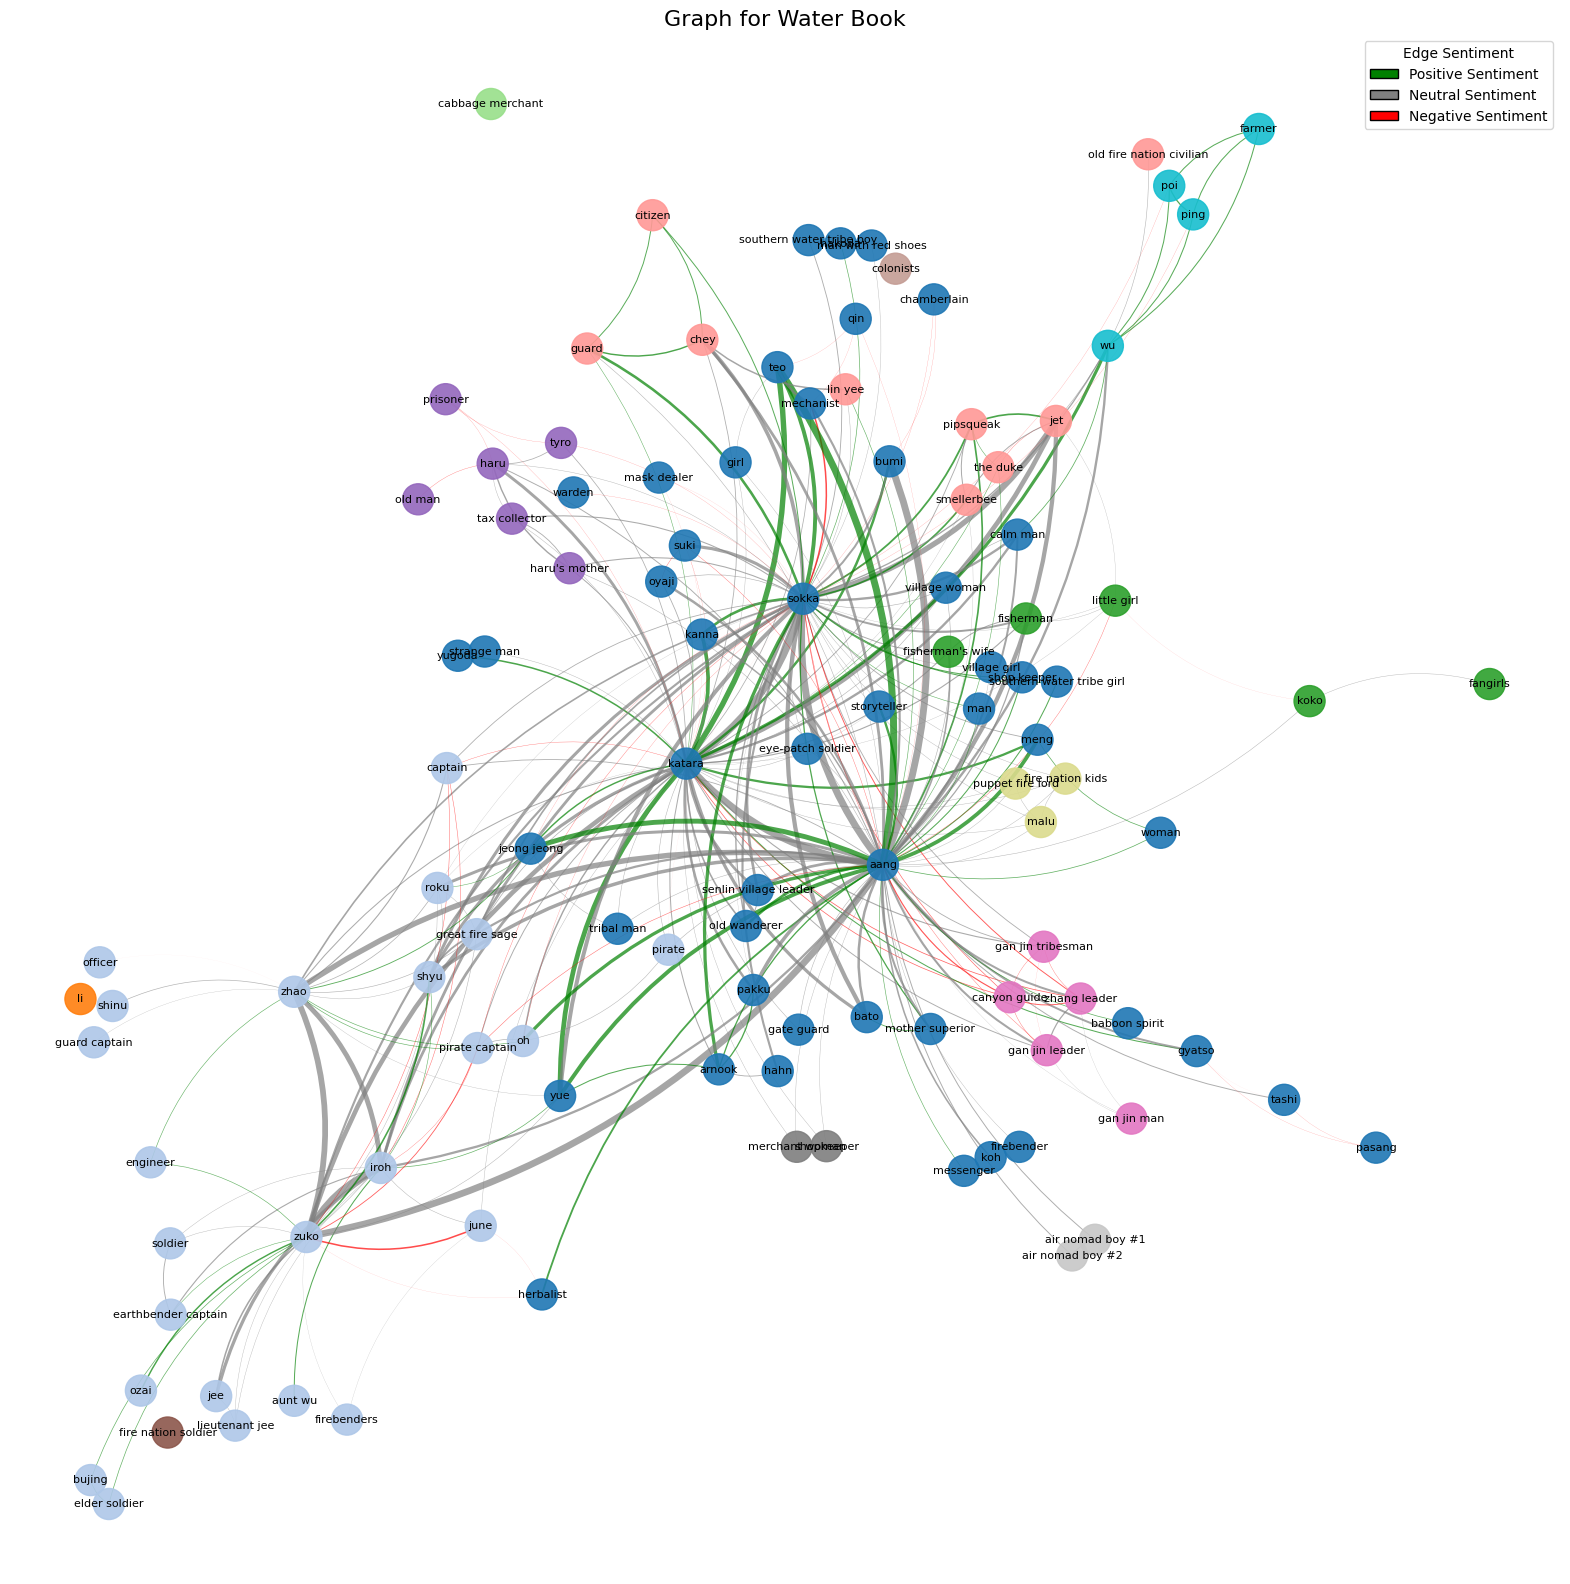

Dynamic Thresholds -> Negative: <-0.4676, Positive: >0.2944


Dynamic Thresholds -> Negative: <-0.4676, Positive: >0.2944


In [ ]:
from matplotlib.patches import Patch, FancyArrowPatch
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Extract sentiment values
sentiments = connections_by_book_df['average_sentiment_between_characters']

def visualize_graph(G, book_name, positions=None):
    # Initialize ForceAtlas2 for layout generation if no positions provided
    if positions is None:
        forceatlas2 = ForceAtlas2(
            outboundAttractionDistribution=False,
            adjustSizes=False,
            edgeWeightInfluence=1,
            jitterTolerance=1,
            barnesHutOptimize=True,
            barnesHutTheta=0,
            multiThreaded=False,
            scalingRatio=0.000001,
            strongGravityMode=False,
            gravity=0.0001,
            verbose=False
        )
        positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

    # Scale positions for better visualization
    positions = {node: (x * 5, y * 5) for node, (x, y) in positions.items()}

    # Detect communities and assign colors
    partition = partitions_by_book_sentiment[book_name]
    unique_communities = set(partition.values())
    community_colors = {com: plt.cm.tab20(i / len(unique_communities)) for i, com in enumerate(unique_communities)}
    node_colors = {node: community_colors[partition[node]] for node in G.nodes()}

    # Define node sizes based on scene count
    scene_counts = nx.get_node_attributes(G, "scene_count")
    max_scene_count = max(scene_counts.values()) if scene_counts else 1
    node_sizes = [500 + (2000 * scene_counts.get(node, 0) / max_scene_count) for node in G.nodes()]


    # Calculate dynamic thresholds
    lower_threshold = sentiments.quantile(0.25)  
    upper_threshold = sentiments.quantile(0.75)  

    print(f"Dynamic Thresholds -> Negative: <{lower_threshold:.4f}, Positive: >{upper_threshold:.4f}")

    # Update edge coloring based on dynamic thresholds
    edge_colors = []
    for u, v, data in G.edges(data=True):
        sentiment = data.get('sentiment', 0)
        if sentiment > upper_threshold:
            edge_colors.append("green")  # Strongly positive
        elif sentiment < lower_threshold:
            edge_colors.append("red")  # Strongly negative
        else:
            edge_colors.append("grey")  # Neutral


    # Define edge widths based on weights
    max_weight = max([data.get('weight', 1) for _, _, data in G.edges(data=True)]) if G.edges else 1
    edge_widths = [min(data.get('weight', 1) * 0.3, 5) for _, _, data in G.edges(data=True)]

    fig, ax = plt.subplots(figsize=(20, 20))
    plt.axis("off")

    # Draw nodes
    nx.draw_networkx_nodes(
        G, positions,
        node_size=node_sizes,
        node_color=[node_colors[node] for node in G.nodes()],
        alpha=0.9,
        ax=ax
    )

    # Draw edges with colors based on sentiment
    for (u, v, data), width, color in zip(G.edges(data=True), edge_widths, edge_colors):
        x1, y1 = positions[u]
        x2, y2 = positions[v]
        alpha_val = min(0.5 + width / 5, 0.7)  # Transparency
        arrow = FancyArrowPatch(
            (x1, y1), (x2, y2),
            connectionstyle="arc3,rad=0.2", 
            color=color,
            alpha=alpha_val,
            linewidth=width,
            arrowstyle='-'
        )
        ax.add_patch(arrow)

    # Add labels for all nodes
    nx.draw_networkx_labels(
        G, positions,
        labels={node: node for node in G.nodes()},
        font_size=8,
        font_color="black",
        ax=ax
    )

    legend_elements = [
        Patch(facecolor="green", edgecolor="black", label="Positive Sentiment"),
        Patch(facecolor="grey", edgecolor="black", label="Neutral Sentiment"),
        Patch(facecolor="red", edgecolor="black", label="Negative Sentiment")
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=10, title="Edge Sentiment")

    plt.title(f"Graph for {book_name} Book", fontsize=16, color="black")
    plt.show()


# Visualize each book
for book_name, G_sentiment in graphs_by_book_sentiment.items():
    visualize_graph(G_sentiment, book_name)


### **Water Book Insights**
- **Team Avatar Dynamics**: 
  - Most interactions among Team Avatar members are neutral, which makes sense given that their relationships are still forming. They’re figuring out their group dynamics as they work together, which aligns with the lower levels of positive sentiment here compared to later books.
  - **Positive Interactions Beyond the Team**: Team Avatar’s positive connections with **Teo**, **his father**, and **Bumi** stand out. These moments highlight the broader theme of forming alliances and building trust early in the series. These characters help shape Aang’s journey, especially by grounding him in his responsibilities as the Avatar.
- **Zuko’s Sentiments**:
  - **Negative Sentiment with June**: It’s fitting that Zuko’s interactions with June are negative, as he tends to be dismissive and authoritarian toward her. This reflects his abrasive personality during the Water Book, where his singular focus on capturing Aang often alienates others.
  - **Surprising Sentiment Toward Ozai**: Despite Ozai’s cruelty, Zuko’s sentiment toward his father skews more positive. This reflects Zuko’s deep yearning for approval and reconciliation, even when he’s being mistreated. It’s a tragic detail that encapsulates Zuko’s internal conflict during this season.
- **Community Structure**:
  - The communities here closely mirror what we’ve seen in earlier analyses, with distinct groups for Team Avatar, Fire Nation antagonists, and supporting characters. This continuity reinforces the early narrative focus on establishing these factions and their dynamics.


### **Earth Book Insights**
- **Zuko’s Shifting Community**:
  - Zuko’s placement with **Iroh**, **Ursa**, and even **Jet** signals his evolving arc. In the Earth Book, Zuko is far more isolated from the Fire Nation, reflecting his time in Ba Sing Se hiding as a refugee. His interactions here are less about his royal lineage and more about survival and introspection.
  - **Azula’s Separate Community**: Azula, meanwhile, remains deeply entrenched in Fire Nation politics and intrigue, explaining why her community includes **Ozai**, **Mai**, and **Ty Lee**, as well as **Bumi**, due to her actions in Omashu. Her connections show the stark contrast between her rising power and Zuko’s fall from grace.
- **Sokka and King Kuei**:
  - Sokka’s strong, positive connection to King Kuei makes perfect sense. In this book, Sokka takes on a key advisory role, trying to warn Kuei about the Day of Black Sun. This interaction underscores Sokka’s growth as a strategist and diplomat.
- **Azula and Ursa**:
  - The weak, negative sentiment between Azula and Ursa reflects their fraught relationship. Ursa’s preference for Zuko over Azula remains a core wound for Azula, and her resentment is palpable throughout the series.
- **Community Evolution**:
  - The divisions in this season emphasize the fractured nature of relationships. Zuko’s estrangement from his family, Azula’s political maneuvering, and Team Avatar’s increasingly complex alliances all come through in these communities.


### **Fire Book Insights**
- **Pipsqueak and Team Avatar**:
  - The inclusion of **Big Bad Hippo** and **The Boulder** in Team Avatar’s community reflects their shifted allegiances. By the Fire Book, they are active participants in the resistance, which fits with the season’s action-packed focus.
- **Aang and Roku**:
  - Aang’s strengthened sentiment and connection to **Roku** underscore his growing understanding of his role as the Avatar. By this point, Aang is leaning more heavily on Roku for guidance, especially as he prepares for the final battle.
- **Zuko and Azula in the Same Community**:
  - The merging of Zuko and Azula into the same community reflects their increased proximity after Zuko’s return to the Fire Nation. However, the dynamics within this community are fraught, with Zuko questioning his place and Azula becoming increasingly unstable.
  - **Iroh’s Separate Community**: Iroh’s separation from Zuko in this season is striking but logical, given his imprisonment and subsequent alignment with the Order of the White Lotus. His interactions are more focused on planning for the final battle alongside **Bumi**, **Jeong Jeong**, **Pakku**, and **Piandao**.
- **Mai and Azula**:
  - The weakening and neutral sentiment between Mai and Azula is significant. Mai’s betrayal at the Boiling Rock marks a turning point, and their interactions become colder and less frequent as Mai shifts her loyalty to Zuko.

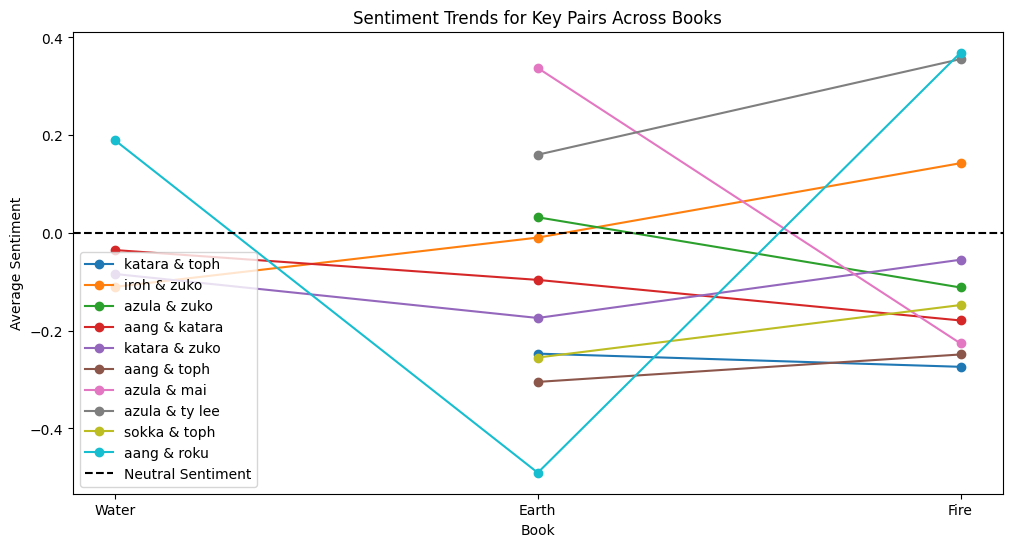

In [9]:
# Extract sentiment trends for key pairs
key_pairs = [('katara', 'toph'), ('iroh', 'zuko'), ('azula', 'zuko'), ('aang', 'katara'), ('katara', 'zuko'), ('aang', 'toph'), ('azula', 'mai'),('azula', 'ty lee'), ('sokka', 'toph'), ('aang', 'roku')]
trend_data = []

for book in books:
    book_data = connections_by_book_df[connections_by_book_df['book'] == book]
    for pair in key_pairs:
        sentiment = book_data[book_data['pair'] == str(pair)]['average_sentiment_between_characters'].values
        trend_data.append({
            'pair': pair,
            'book': book,
            'sentiment': sentiment[0] if len(sentiment) > 0 else None
        })

# Convert to DataFrame for plotting
trend_df = pd.DataFrame(trend_data)

# Plot sentiment trends
plt.figure(figsize=(12, 6))
for pair in key_pairs:
    pair_data = trend_df[trend_df['pair'] == pair]
    plt.plot(pair_data['book'], pair_data['sentiment'], marker='o', label=f"{pair[0]} & {pair[1]}")

plt.axhline(0, color="black", linestyle="--", label="Neutral Sentiment")
plt.title("Sentiment Trends for Key Pairs Across Books")
plt.xlabel("Book")
plt.ylabel("Average Sentiment")
plt.legend()
plt.show()


The low sentiment between Katara and Aang might not intuitively align with their overall positive and supportive relationship throughout the series. However, this can occur due to several reasons:

### **1. Sentiment Analyzer's Limitations**
- **Context Ignorance:** Sentiment analysis models (even advanced ones like BERT) can misinterpret the tone of dialogues, especially if sarcasm, jokes, or context-specific meanings are involved.
- **Neutral/Negative Words:** Even in positive relationships, characters may argue, express frustration, or discuss serious topics that are misclassified as negative sentiment.

### **2. Volume of Interactions**
- If Katara and Aang have a significant amount of dialogue together, the overall average sentiment might be diluted by a few strongly negative moments (e.g., arguments or moments of tension).

### **3. Key Episodes or Moments**
- Specific scenes where Katara expresses doubt or frustration with Aang (e.g., when Aang runs away or makes impulsive decisions) might skew the sentiment score.
- For example:
  - In "The Crossroads of Destiny," Katara is upset with Aang's decision-making.
  - During "The Southern Raiders," Katara confronts darker emotions, which might be reflected in their interactions.

### **4. Misclassification of Neutral Sentiment**
- Neutral dialogue (e.g., descriptive or factual statements) might be weighted as slightly negative or contribute less to positive sentiment scores.


